## I/O and Preprocessing 

In [466]:
%matplotlib inline
import pandas as pd

In [300]:
software_url = 'https://docs.google.com/spreadsheets/d/1Sjp9PG75Ap-5YBvOWZ-cCUGkNhN41LZlz3OL-gJ-tKU/export?format=csv&id=1Sjp9PG75Ap-5YBvOWZ-cCUGkNhN41LZlz3OL-gJ-tKU&gid=1702131855'
usage_url = 'https://docs.google.com/spreadsheets/d/1Sjp9PG75Ap-5YBvOWZ-cCUGkNhN41LZlz3OL-gJ-tKU/export?format=csv&id=1Sjp9PG75Ap-5YBvOWZ-cCUGkNhN41LZlz3OL-gJ-tKU&gid=1374288343'

In [301]:
software_data = pd.read_csv(software_url).dropna(how='all')
usage_data = pd.read_csv(usage_url).dropna(how='all')

In [265]:
def whitestrip_elements(x):
    '''
    Eliminates whitespace on left/right for strings or strings that begin with -
    '''
    if isinstance(x, str):
        if x[0] == '-':
            return None
        return x.lstrip().rstrip()
    return x

In [455]:
software = software_data.applymap(whitestrip_elements)
usage = usage_data.applymap(whitestrip_elements)

## Nodes 

### Software

In [445]:
all_names = software['Name'].unique()
software_df = pd.DataFrame(pd.Series(all_names).dropna().drop_duplicates())
software_df.columns = ['label']
software_df['type'] = 'software'

### Tags 

In [446]:
tag_list = pd.Series() 
for col in software.ix[:, 4:23].columns:
    tag_list = tag_list.append((software[col].dropna()))
tag_list = sorted(list(set(tag_list)))
#tag_list = sorted([tag for tag in tag_list if tag[0]!='-'])

In [447]:
tag_df = pd.DataFrame(pd.Series(tag_list).dropna().drop_duplicates())
tag_df.columns = ['label']
tag_df['type'] = 'tag'

### Organizations 

In [448]:
all_orgs = usage_data['Name'].unique()
org_df = pd.DataFrame(pd.Series(all_orgs).dropna().drop_duplicates())
org_df.columns = ['label']
org_df['type'] = 'org'

### Aggregate all nodes 

In [449]:
node_df = pd.DataFrame()
node_df = node_df.append(tag_df, ignore_index=True)
node_df = node_df.append(software_df, ignore_index=True)
node_df = node_df.append(org_df, ignore_index=True)

In [450]:
node_df = node_df.sort_values(by='label').reset_index()
node_df['id'] = node_df.index

In [451]:
node_df[['id', 'label', 'type']].to_csv('nodes.csv', index=False)

In [452]:
node_df.index = node_df['label']

## Edges

In [ ]:
def build_org_software_dict(row):
    '''
    Builds a dictionary between organization and software 
    {'Name': 'Org1', 'Uses': ['tag1', 'tag2']}
    '''
    name = row['Name']
    uses = list(row.ix[3:7].dropna())
    org_name_dict = {'Name': name, 'Uses': uses}
    return org_name_dict

org_software_dict = [build_org_software_dict(row) for idx, row in usage.iterrows()] 

In [459]:
def build_software_tag_dict(row):
    '''
    Builds a dictionary as follows:
    {'Name': 'Software_Name', 'Tags': ['tag1', 'tag2']}
    '''
    name = row['Name']
    tags = list(row.ix[4:23].dropna())
    nt_dict = {'Name': name, 'Tags': tags}
    return nt_dict


software_dict = [build_software_tag_dict(row) for idx, row in software.iterrows()]

In [496]:
def build_edges(d, label_type='id', src_name='Name', tgt_name='Tags', src_type='software', tgt_type='tag'):
    '''
    Builds list of tuples to represent edges between the source and target
    Returns [(source1, target1), (source2, target2)]
    
    label_type: {'id', 'label'}
    '''
    source = d[src_name]
    targets = d[tgt_name]
    edge_list = []
    node_type_grp = node_df.groupby('type') #groupby label type
    source_df = node_type_grp.get_group(src_type) #df of names
    target_df = node_type_grp.get_group(tgt_type) #df of tags
    source_id = source_df.ix[source, label_type] #map source_name to source_id
    for target in targets:
        try:
            target_id = target_df.ix[target, label_type] #map target_name to target_id
            edge_list.append((source_id, target_id)) #append (source_id, target_id)
        except:
            pass
    return edge_list

In [497]:
edge_list = []
for d in software_dict:
    edge_list += build_edges(d, label_type='label')

In [498]:
edge_df = pd.DataFrame(edge_list)
edge_df.columns = ['Source', 'Target']
edge_df.to_csv('edges.csv', index=False)

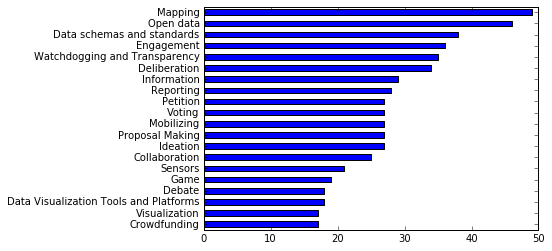

In [499]:
edge_df['Target'].value_counts(ascending=True).tail(n=20).plot(kind='barh')

## Organization - Software Usage 

In [510]:
org_software_edges = []
for d in org_software_dict:
    org_software_edges += build_edges(d, label_type='label', src_name='Name', tgt_name='Uses', src_type='org', tgt_type='software')

In [513]:
software_tag_grps = edge_df.groupby('Source')

In [529]:
from collections import defaultdict
tag_count = defaultdict(int)
for edge in org_software_edges:
    _, software = edge
    if software in software_tag_grps.groups.keys():
        software_tag_df = software_tag_grps.get_group(software)
        if not software_tag_df.empty:
            for tag in software_tag_df['Target']:
                tag_count[tag] += 1

# Visualization

## Histogram of Tags by Available Software

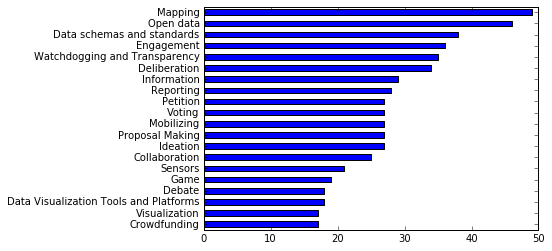

In [542]:
edge_df['Target'].value_counts(ascending=True).tail(n=20).plot(kind='barh')

## Histogram of Tags based on Software Usage by Initiatives

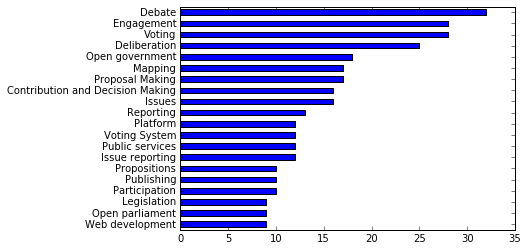

In [543]:
pd.Series(tag_count).sort_values(ascending=True).tail(n=20).plot(kind='barh')